# 1. Import Libraries

In [194]:
import os
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import pydotplus

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import r2_score
from datetime import datetime

from typing import Any, Literal
from pydantic import BaseModel

# 2. Load the Dataset

In [195]:
path = '/content/6 class csv.csv'
dataset = pd.read_csv(path)
print("Dataset Loaded:\n", dataset.head())

Dataset Loaded:
    Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
0             3068          0.002400        0.1700                   16.12   
1             3042          0.000500        0.1542                   16.60   
2             2600          0.000300        0.1020                   18.70   
3             2800          0.000200        0.1600                   16.65   
4             1939          0.000138        0.1030                   20.06   

   Star type Star color Spectral Class  
0          0        Red              M  
1          0        Red              M  
2          0        Red              M  
3          0        Red              M  
4          0        Red              M  


In [196]:
print(dataset.dtypes)

Temperature (K)             int64
Luminosity(L/Lo)          float64
Radius(R/Ro)              float64
Absolute magnitude(Mv)    float64
Star type                   int64
Star color                 object
Spectral Class             object
dtype: object


# 3. Preprocess the Dataset

In [197]:
def preprocess_dataset(dataset, target_columns):

    # Encode categorical variables
    le = LabelEncoder()

    for column in dataset.select_dtypes(include=['object']).columns:
        dataset[column] = le.fit_transform(dataset[column])

    # Split dataset
    X = dataset.drop(columns=target_columns)  # Features
    y = dataset[target_columns] # Target

    # Adding some null values
    keys = [(row, col) for row in range(X.shape[0]) for col in range(X.shape[1])]
    for row, col in random.sample(keys, int(round(0.1 * len(keys)))):
        X.iat[row, col] = np.nan

    X = X.to_numpy()
    y = y.to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [198]:
X_train, X_test, y_train, y_test = preprocess_dataset(dataset, target_columns=['Star type'])
print("Data Preprocessing Completed.")

Data Preprocessing Completed.


# 4. Utilities

Tree Node

In [199]:
class Node(BaseModel):
    kind: Literal["parent", "leaf"]


class ParentNode(Node):
    kind: Literal["parent"] = "parent"
    feature: int
    threshold: float | str
    impurity: float
    left: Node
    right: Node


class LeafNode(Node):
    kind: Literal["leaf"] = "leaf"
    value: float

Visualisation

In [200]:
def convert_reference_treenode2dict(tree, tree_type, node_id=0):
    node_dict = {}
    node_dict["beta"] = tree.threshold[node_id]
    node_dict["feature_idx"] = tree.feature[node_id]

    if tree_type == "classification":
        node_dict["entropy"] = tree.impurity[node_id]
    elif tree_type == "regression":
        node_dict["uncertainty"] = tree.impurity[node_id]
        node_dict["value"] = tree.value[node_id][0, 0]

    is_split_node = tree.children_left[node_id] != tree.children_right[node_id]
    if is_split_node:
        node_dict["left"] = convert_reference_treenode2dict(tree, tree_type, tree.children_left[node_id])
        node_dict["right"] = convert_reference_treenode2dict(tree, tree_type, tree.children_right[node_id])
    else:
        if tree_type == "classification":
            node_dict["lbl"] = np.argmax(tree.value[node_id])
            node_dict["prob"] = np.max(tree.value[node_id])

    return node_dict

In [201]:
def convert_custom_treenode2dict(tree, tree_type):
    node_dict = {}
    match tree:
        case ParentNode(threshold=threshold, feature=feature, left=left, right=right):
            node_dict["beta"] = tree.threshold
            node_dict["feature_idx"] = tree.feature

        case LeafNode(value=value):
            node_dict["beta"] = 0
            node_dict["feature_idx"] = -2

    match tree:
        case ParentNode(threshold=threshold, feature=feature, left=left, right=right):
            if tree_type == "classification":
                node_dict["entropy"] = tree.impurity
            elif tree_type == "regression":
                node_dict["uncertainty"] = tree.impurity
                node_dict["value"] = -2

        case LeafNode(value=value):
            if tree_type == "classification":
                node_dict["entropy"] = -2
            elif tree_type == "regression":
                node_dict["uncertainty"] = -2
                node_dict["value"] = tree.value

    match tree:
        case ParentNode(threshold=threshold, feature=feature, left=left, right=right):
            node_dict["left"] = convert_custom_treenode2dict(left, tree_type)
            node_dict["right"] = convert_custom_treenode2dict(right, tree_type)

        case LeafNode(value=value):
            if tree_type == "classification":
                node_dict["lbl"] = int(value)
                node_dict["prob"] = 1.00

    return node_dict

In [202]:
def visualize_tree(tree, path, tree_source, tree_type, max_depth=4, criterion="entropy"):
    if tree_source == "reference":
        tree_dict = convert_reference_treenode2dict(tree, tree_type)
    elif tree_source == "custom":
        tree_dict = convert_custom_treenode2dict(tree, tree_type)
    else:
        raise ValueError(f"Wrong tree source: {tree_source}")

    dot_data = pydotplus.Dot()
    current_depth = 0

    def add_node(parent_name, node, current_depth):
        if tree_type == "classification":
            if node["feature_idx"] == -2: # this means that we have a leaf
                label = f'type = {node["lbl"]}\nprob = {np.max(node["prob"]):.2f}'
            else:
                label = f'x[{node["feature_idx"]}] <= {node["beta"]:.2f}'+\
                    f'\n{criterion} = {node["entropy"]:.4f}'
        elif tree_type == "regression":
            if node["feature_idx"] == -2: # this means that we have a leaf
                label = f'uncertainty = {0.0000:.4f}' +\
                    f'\nvalue = {node["value"]:.2f}'
            else:
                label = f'x[{node["feature_idx"]}] <= {node["beta"]:.2f}'+\
                    f'\nuncertainty = {node["uncertainty"]:.4f}'
        else: raise ValueError(f"Wrong tree type: {tree_type}")

        dot_data.add_node(pydotplus.Node(f'{parent_name}', shape='box', label=label))
        current_depth += 1
        if current_depth > max_depth: return
        if "left" in node.keys():
            dot_data.add_edge(pydotplus.Edge(parent_name, f'{parent_name}_{id(node["left"])}', label="yes"))
            add_node(f'{parent_name}_{id(node["left"])}', node["left"], current_depth=current_depth)
        if "right" in node.keys():
            dot_data.add_edge(pydotplus.Edge(parent_name, f'{parent_name}_{id(node["right"])}', label="no"))
            add_node(f'{parent_name}_{id(node["right"])}', node["right"], current_depth=current_depth)

    add_node("Tree", tree_dict, current_depth)
    dot_data.write(path, format="png")

# 5. Decision Tree Classifier

In [203]:
MAX_DEPTH = 6

## 5.1. Reference Decision Tree Classifier

In [204]:
tree_ref = DecisionTreeClassifier(criterion="entropy", max_depth=MAX_DEPTH, random_state=42)
tree_ref.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)


Reference Decision Tree Classifier

Execution Time: 1047 mcs

Accuracy: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.71      0.83         7
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        11

    accuracy                           0.96        48
   macro avg       0.97      0.95      0.95        48
weighted avg       0.97      0.96      0.96        48


Confusion Matrix:



<Axes: >

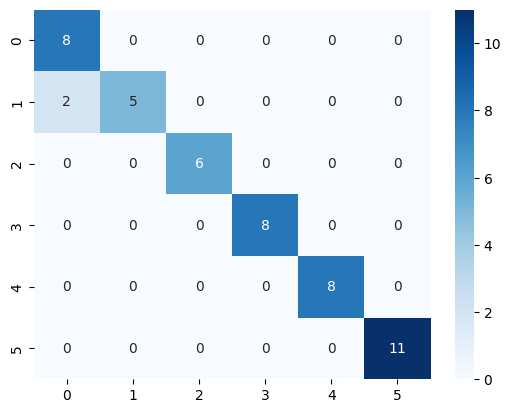

In [205]:
start_time = datetime.now()

y_pred = tree_ref.predict(X_test)

end_time = datetime.now()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"\nReference Decision Tree Classifier")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n")
sns.heatmap(matrix, annot=True, cmap="Blues")

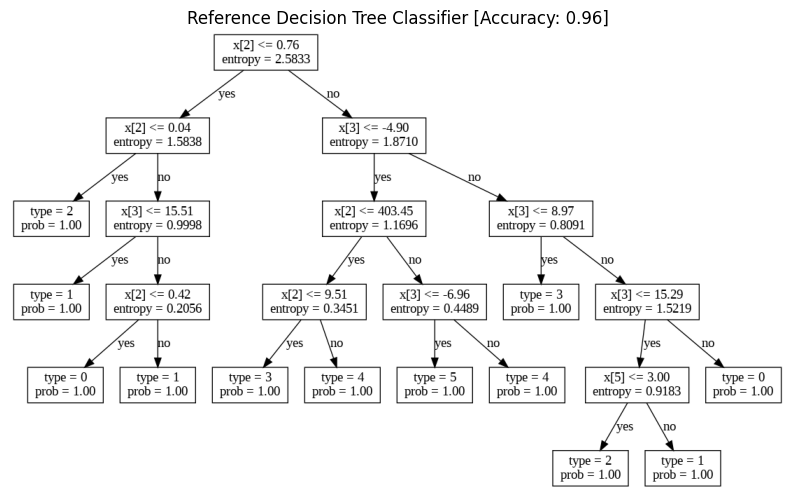

In [206]:
visualize_tree(tree_ref.tree_, path="/content/classification_reference.png", tree_source="reference", tree_type="classification", max_depth=MAX_DEPTH)

plt.figure(figsize=(10, 8))
plt.imshow(Image.open("/content/classification_reference.png"))
plt.axis("off")
plt.title(f'Reference Decision Tree Classifier [Accuracy: {accuracy:.2f}]')

plt.savefig("/content/classification_reference.png", bbox_inches="tight")

## 5.2. Custom Decision Tree Classifier

In [207]:
class CustomDecisionTreeClassifier:
    def __init__(self, min_samples_split=2, max_depth=5, criterion="entropy"):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.criterion = criterion
        self.tree = None

    def entropy(self, y):
        # Handle empty arrays
        if len(y) == 0:
            return 0.0

        # Calculate probabilities of each class
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)

        # Calculate entropy using formula: -sum(p * log2(p))
        entropy = -np.sum(probabilities * np.log2(probabilities + np.finfo(float).eps))
        return entropy

    def information_gain(self, X_column, y, threshold):
        # Split the data based on threshold
        if np.isnan(threshold):
            # If threshold is NaN, return 0 gain
            return 0.0

        try:
            left_mask = X_column <= threshold
            right_mask = ~left_mask
        except TypeError:
            raise ValueError(f"Threshold must be a number for numeric features, got {threshold}: {type(threshold)}")

        # Get the child node samples
        left_y = y[left_mask]
        right_y = y[right_mask]

        if self.criterion == "entropy":
            # Calculate parent entropy
            parent_entropy = self.entropy(y)

            # Calculate weights of splits
            n_samples = len(y)
            w_left = len(left_y) / n_samples
            w_right = len(right_y) / n_samples

            # Calculate weighted child entropy
            child_entropy = w_left * self.entropy(left_y) + w_right * self.entropy(right_y)
            return parent_entropy - child_entropy

        elif self.criterion == "donskoy":  # donskoy criterion
            n_total = len(y)
            n_left = len(left_y)
            n_right = len(right_y)

            # Normalization factor
            norm_factor = (n_left * n_right) / (n_total ** 2)

            # Calculate class proportions difference
            total_diff = 0
            for class_label in np.unique(y):
                left_prop = np.sum(left_y == class_label) / n_left if n_left > 0 else 0
                right_prop = (np.sum(right_y == class_label) / n_right if n_right > 0 else 0)
                total_diff += abs(left_prop - right_prop)

            return norm_factor * total_diff

    def best_split(self, X, y):
        n_features = X.shape[1]
        best_gain = -np.inf
        best_feature = None
        best_threshold = None

        for feature in range(n_features):
            unique_values = np.unique(X[:, feature])

            for threshold in unique_values:
                gain = self.information_gain(X[:, feature], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def build_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        n_classes = len(np.unique(y))

        # Base cases
        if n_classes == 1:
            return LeafNode(value=y[0])
        if depth >= self.max_depth or n_samples < self.min_samples_split:
            return LeafNode(value=np.argmax(np.bincount(y.flatten())))

        # Find the best split
        best_feature, best_threshold, best_gain = self.best_split(X, y)

        # Split the data
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        # Recursively build the left and right subtrees
        left_subtree = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.build_tree(X[right_mask], y[right_mask], depth + 1)

        return ParentNode(feature=best_feature, threshold=best_threshold, impurity=best_gain, left=left_subtree, right=right_subtree)

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def evaluate_accuracy(self, node, X, y):
        predictions = []
        for row in X:
            current = node
            while True:
                match current:
                    # Navigate until we hit a leaf
                    case LeafNode(value=value):
                        predictions.append(value)
                        break

                    case ParentNode(threshold=threshold, feature=feature, left=left, right=right):
                        go_left = row[feature] <= threshold
                        if go_left:
                            current = left
                        else:
                            current = right

                    case _:
                        raise ValueError(f"Invalid node: {current}")

        predictions = [int(i) for i in predictions]
        return accuracy_score(y, predictions)

    def should_prune(self, node, X, y):
        accuracy_before = self.evaluate_accuracy(node, X, y)

        temp_node = LeafNode(value=np.argmax(np.bincount(y.flatten())))

        accuracy_after = self.evaluate_accuracy(temp_node, X, y)

        return accuracy_after >= accuracy_before, accuracy_after

    def prune_recursive(self, node, X, y):
        match node:
            # Base case: if we're at a leaf, return
            case LeafNode():
                return node

            case ParentNode(threshold=threshold, feature=feature, left=left, right=right):
                # Recursively prune children first
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                if len(X[left_mask]) > 0:
                    node.left = self.prune_recursive(left, X[left_mask], y[left_mask])
                if len(X[right_mask]) > 0:
                    node.right = self.prune_recursive(right, X[right_mask], y[right_mask])

                # After pruning children, check if this node should be pruned
                should_prune, _ = self.should_prune(node, X, y)
                if should_prune:
                    return LeafNode(value=np.argmax(np.bincount(y.flatten())))

                return node
            case _:
                raise ValueError(f"Invalid node: {node}")

    def prune(self, X_test, y_test):

        if self.tree is None:
            raise ValueError("Tree must be fitted before pruning")

        self.tree = self.prune_recursive(self.tree, X_test, y_test)

    def predict_single(self, row):
        node = self.tree
        while True:
            match node:
                case LeafNode(value=value):
                    return value
                case ParentNode(threshold=threshold, feature=feature, left=left, right=right):
                    go_left = row[feature] <= threshold

                    if go_left:
                        node = left
                    else:
                        node = right
                case _:
                    raise ValueError(f"Invalid node: {node}")

    def predict(self, X):
        return np.array([self.predict_single(row) for row in X])

### Classifier with criterion **Entropy**

In [208]:
custom_tree_entropy = CustomDecisionTreeClassifier(max_depth=MAX_DEPTH, criterion="entropy")
custom_tree_entropy.fit(X_train, y_train)


Costum Decision Tree Classifier with criterion Entropy

Execution Time: 806 mcs

Accuracy: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.75      0.86      0.80         7
           2       1.00      1.00      1.00         6
           3       0.88      0.88      0.88         8
           4       0.89      1.00      0.94         8
           5       1.00      1.00      1.00        11

    accuracy                           0.92        48
   macro avg       0.92      0.91      0.91        48
weighted avg       0.92      0.92      0.92        48


Confusion Matrix:



<Axes: >

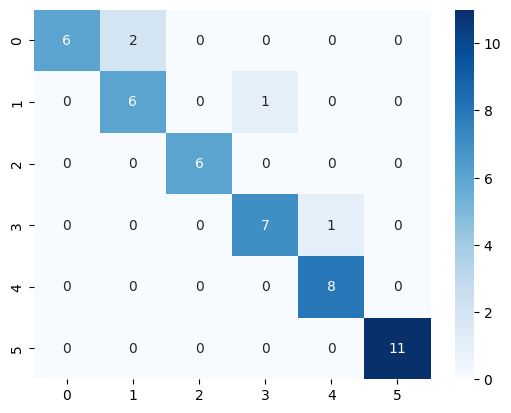

In [209]:
start_time = datetime.now()

y_pred = custom_tree_entropy.predict(X_test)

end_time = datetime.now()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"\nCostum Decision Tree Classifier with criterion Entropy")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n")
sns.heatmap(matrix, annot=True, cmap="Blues")

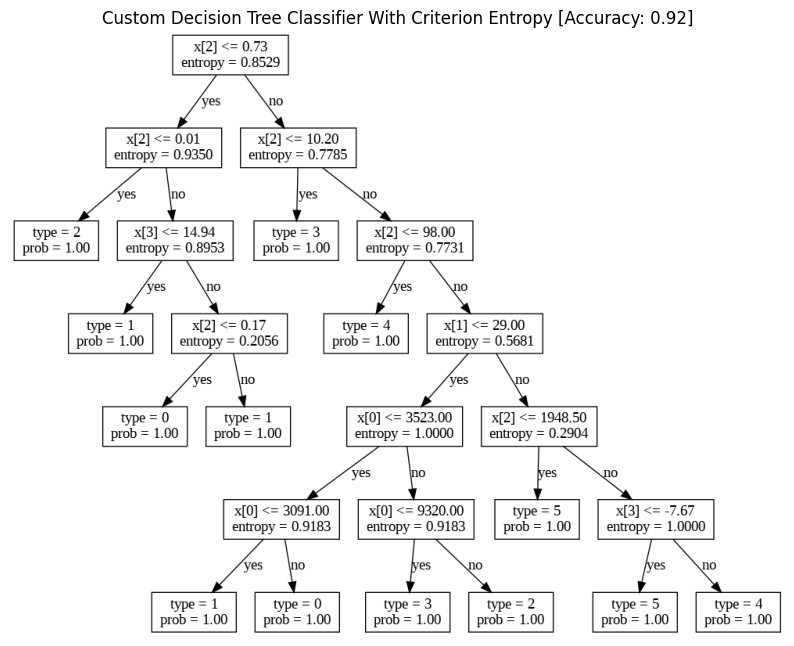

In [210]:
visualize_tree(custom_tree_entropy.tree, path="/content/classification_entropy_custom.png",
               tree_source="custom", tree_type="classification", max_depth=MAX_DEPTH, criterion="entropy")

plt.figure(figsize=(10, 8))
plt.imshow(Image.open("/content/classification_entropy_custom.png"))
plt.axis("off")
plt.title(f'Custom Decision Tree Classifier With Criterion Entropy [Accuracy: {accuracy:.2f}]')

plt.savefig("/content/classification_entropy_custom.png", bbox_inches="tight")

In [211]:
custom_tree_entropy.prune(X_test, y_test)


Costum Decision Tree Classifier with criterion Entropy after prunning

Execution Time: 793 mcs

Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       1.00      0.88      0.93         8
           4       0.89      1.00      0.94         8
           5       1.00      1.00      1.00        11

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48


Confusion Matrix:



<Axes: >

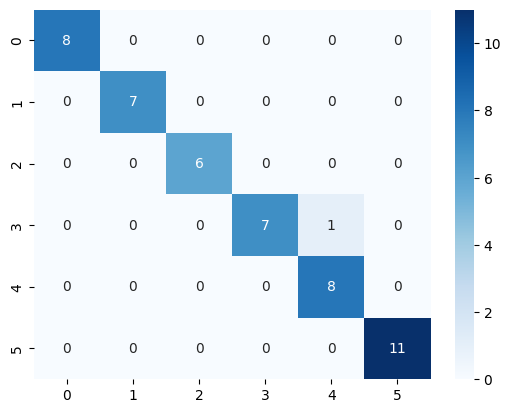

In [212]:
start_time = datetime.now()

y_pred = custom_tree_entropy.predict(X_test)

end_time = datetime.now()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"\nCostum Decision Tree Classifier with criterion Entropy after prunning")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n")
sns.heatmap(matrix, annot=True, cmap="Blues")

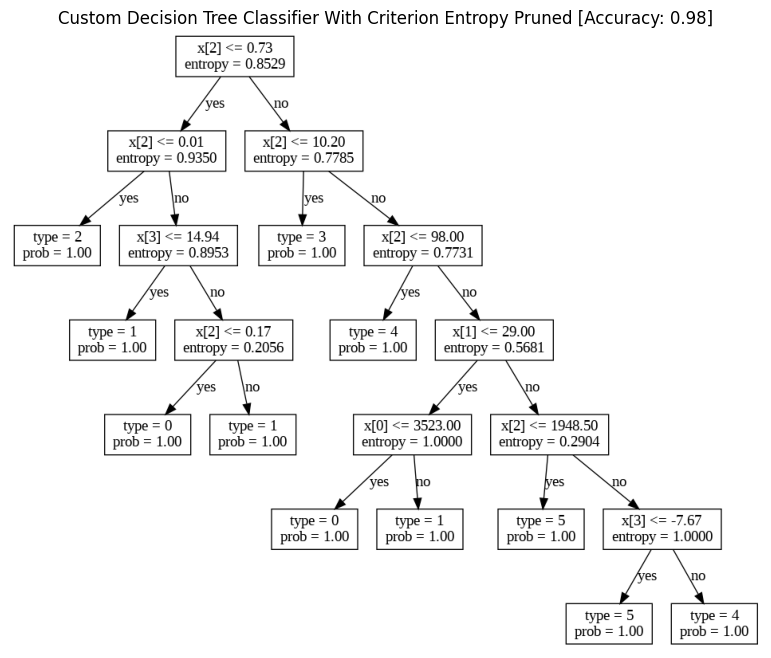

In [213]:
visualize_tree(custom_tree_entropy.tree, path="/content/classification_entropy_custom_prun.png",
               tree_source="custom", tree_type="classification", max_depth=MAX_DEPTH, criterion="entropy")

plt.figure(figsize=(10, 8))
plt.imshow(Image.open("/content/classification_entropy_custom_prun.png"))
plt.axis("off")
plt.title(f'Custom Decision Tree Classifier With Criterion Entropy Pruned [Accuracy: {accuracy:.2f}]')

plt.savefig("/content/classification_entropy_custom_prun.png", bbox_inches="tight")

### Classifier with criterion **Donskoy**

In [214]:
custom_tree_donskoy = CustomDecisionTreeClassifier(max_depth=MAX_DEPTH, criterion="donskoy")
custom_tree_donskoy.fit(X_train, y_train)


Costum Decision Tree Classifier with criterion Donskoy

Execution Time: 524 mcs

Accuracy: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.86      0.92         7
           2       0.86      1.00      0.92         6
           3       0.88      0.88      0.88         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        11

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.95        48
weighted avg       0.96      0.96      0.96        48


Confusion Matrix:



<Axes: >

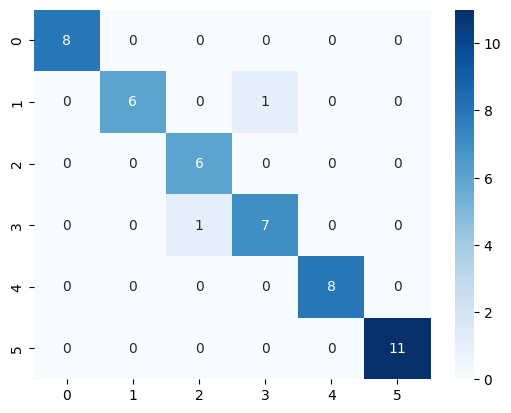

In [215]:
start_time = datetime.now()

y_pred = custom_tree_donskoy.predict(X_test)

end_time = datetime.now()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"\nCostum Decision Tree Classifier with criterion Donskoy")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n")
sns.heatmap(matrix, annot=True, cmap="Blues")

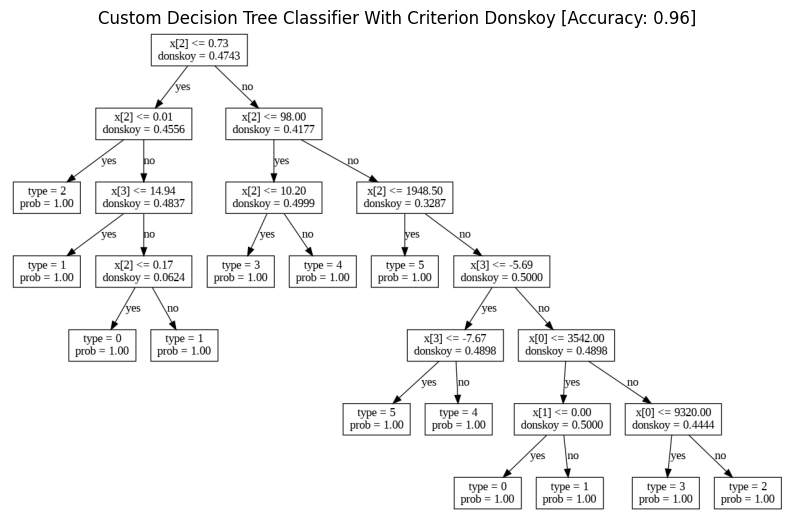

In [216]:
visualize_tree(custom_tree_donskoy.tree, path="/content/classification_donskoy_custom.png",
               tree_source="custom", tree_type="classification", max_depth=MAX_DEPTH, criterion="donskoy")

plt.figure(figsize=(10, 8))
plt.imshow(Image.open("/content/classification_donskoy_custom.png"))
plt.axis("off")
plt.title(f'Custom Decision Tree Classifier With Criterion Donskoy [Accuracy: {accuracy:.2f}]')

plt.savefig("/content/classification_donskoy_custom.png", bbox_inches="tight")

In [217]:
custom_tree_donskoy.prune(X_test, y_test)


Costum Decision Tree Classifier with criterion Donskoy after prunning

Execution Time: 772 mcs

Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         6
           3       1.00      0.88      0.93         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        11

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48


Confusion Matrix:



<Axes: >

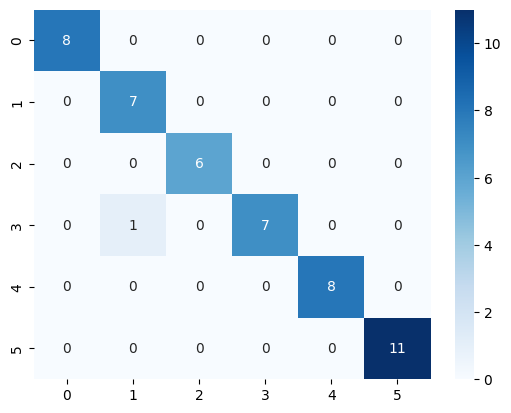

In [218]:
start_time = datetime.now()

y_pred = custom_tree_donskoy.predict(X_test)

end_time = datetime.now()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"\nCostum Decision Tree Classifier with criterion Donskoy after prunning")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n")
sns.heatmap(matrix, annot=True, cmap="Blues")

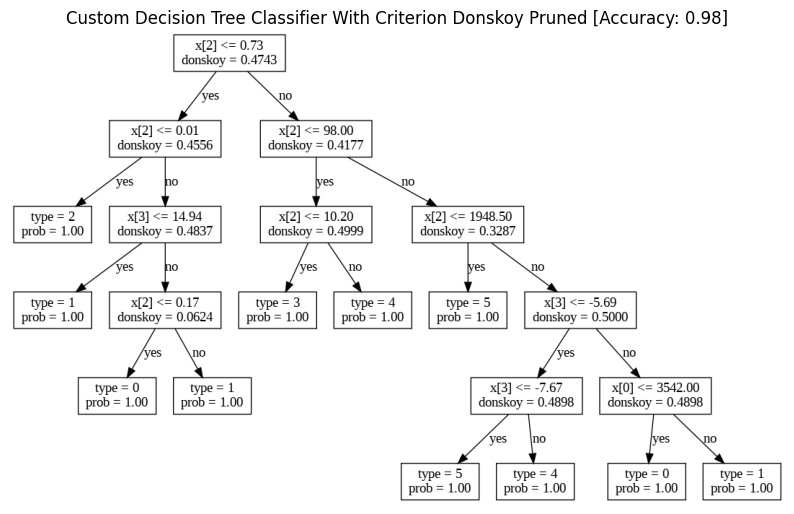

In [219]:
visualize_tree(custom_tree_donskoy.tree, path="/content/classification_donskoy_custom_prun.png",
               tree_source="custom", tree_type="classification", max_depth=MAX_DEPTH, criterion="donskoy")

plt.figure(figsize=(10, 8))
plt.imshow(Image.open("/content/classification_donskoy_custom_prun.png"))
plt.axis("off")
plt.title(f'Custom Decision Tree Classifier With Criterion Donskoy Pruned [Accuracy: {accuracy:.2f}]')

plt.savefig("/content/classification_donskoy_custom_prun.png", bbox_inches="tight")

# 6. Decision Tree Regressor

In [220]:
MAX_DEPTH = 6

## 6.1. Reference Decision Tree Regressor

In [221]:
tree_ref = DecisionTreeRegressor(criterion="squared_error", max_depth=MAX_DEPTH, random_state=42)
tree_ref.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, random_state=42)

In [222]:
start_time = datetime.now()

y_pred = tree_ref.predict(X_test)

end_time = datetime.now()

# Metrics
r2 = r2_score(y_test, y_pred)

print(f"\nReference Decision Tree Regressor")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nR2 score: {r2:.4f}")


Reference Decision Tree Regressor

Execution Time: 932 mcs

R2 score: 0.9870


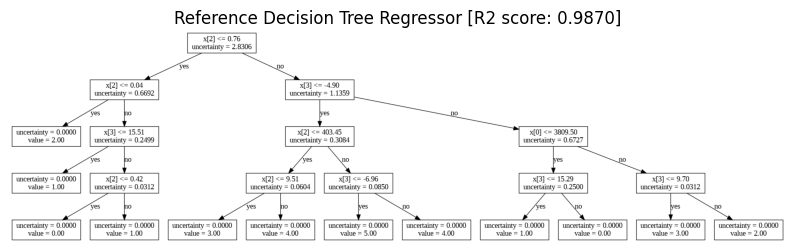

In [223]:
visualize_tree(tree_ref.tree_, path="/content/regression_reference.png", tree_source="reference", tree_type="regression", max_depth=MAX_DEPTH)

plt.figure(figsize=(10, 8))
plt.imshow(Image.open("/content/regression_reference.png"))
plt.axis("off")
plt.title(f'Reference Decision Tree Regressor [R2 score: {r2:.4f}]')

plt.savefig("/content/regression_reference.png", bbox_inches="tight")

## 6.2. Custom Decision Tree Regressor

In [224]:
class CustomDecisionTreeRegressor:
    def __init__(self, min_samples_split: int = 2, max_depth: int = 5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.tree = None

    def calculate_mse(self, X_column, y, threshold):
        # Split the data based on threshold
        if np.isnan(threshold):
            return np.inf

        left_mask = X_column <= threshold
        right_mask = ~left_mask

        # Get the child node samples
        left_y = y[left_mask]
        right_y = y[right_mask]

        # If split creates empty node or single-element node, return infinity
        if len(left_y) <= 0 or len(right_y) <= 0:
            return np.inf

        # Calculate MSE for both splits
        left_mean = np.mean(left_y, where=~np.isnan(left_y))
        right_mean = np.mean(right_y, where=~np.isnan(right_y))

        # Handle potential division by zero or nan values
        mse_left = np.mean((left_y - left_mean) ** 2, where=~np.isnan(left_y))
        mse_right = np.mean((right_y - right_mean) ** 2, where=~np.isnan(right_y))

        # Calculate weighted average MSE
        n_left = len(left_y)
        n_right = len(right_y)
        n_total = n_left + n_right

        weighted_mse = (n_left * mse_left + n_right * mse_right) / n_total
        return weighted_mse

    def find_best_split(self, X, y):
        n_features = X.shape[1]
        best_mse = np.inf
        best_feature = None
        best_threshold = None

        current_mse = np.mean((y - np.mean(y, where=~np.isnan(y))) ** 2, where=~np.isnan(y))

        for feature in range(n_features):
            unique_values = np.sort(np.unique(X[:, feature]))
            for threshold in unique_values:
                if np.isnan(threshold):
                    continue
                mse = self.calculate_mse(X[:, feature], y, threshold)
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature
                    best_threshold = threshold

        # If no split improves MSE, return None
        if best_mse >= current_mse:
            return None, None, None

        return best_feature, best_threshold, best_mse

    def build_tree(self, X, y, depth: int = 0):
        n_samples = X.shape[0]

        # Base cases
        if depth >= self.max_depth or n_samples < self.min_samples_split:
            return LeafNode(value=np.mean(y))

        # Find the best split
        best_feature, best_threshold, best_mse = self.find_best_split(X, y)

        # If no good split is found, return leaf
        if best_feature is None:
            return LeafNode(value=np.mean(y, where=~np.isnan(y)))

        # Split the data
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        # Recursively build the left and right subtrees
        left_subtree = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.build_tree(X[right_mask], y[right_mask], depth + 1)

        return ParentNode(feature=best_feature, threshold=best_threshold, impurity=best_mse, left=left_subtree, right=right_subtree)

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def evaluate_r2(self, node, X, y):
        predictions = []
        for row in X:
            current = node
            while True:
                match current:
                    # Navigate until we hit a leaf
                    case LeafNode(value=value):
                        predictions.append(value)
                        break

                    case ParentNode(threshold=threshold, feature=feature, left=left, right=right):
                        go_left = row[feature] <= threshold
                        if go_left:
                            current = left
                        else:
                            current = right

                    case _:
                        raise ValueError(f"Invalid node: {current}")

        predictions = [int(i) for i in predictions]
        return r2_score(y, predictions)

    def should_prune(self, node, X, y):
        r2_before = self.evaluate_r2(node, X, y)

        temp_node = LeafNode(value=np.argmax(np.bincount(y.flatten())))

        r2_after = self.evaluate_r2(temp_node, X, y)

        return r2_after >= r2_before, r2_after

    def prune_recursive(self, node, X, y):
        match node:
            # Base case: if we're at a leaf, return
            case LeafNode():
                return node

            case ParentNode(threshold=threshold, feature=feature, left=left, right=right):
                # Recursively prune children first
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                if len(X[left_mask]) > 0:
                    node.left = self.prune_recursive(left, X[left_mask], y[left_mask])
                if len(X[right_mask]) > 0:
                    node.right = self.prune_recursive(right, X[right_mask], y[right_mask])

                # After pruning children, check if this node should be pruned
                should_prune, _ = self.should_prune(node, X, y)
                if should_prune:
                    return LeafNode(value=np.argmax(np.bincount(y.flatten())))

                return node
            case _:
                raise ValueError(f"Invalid node: {node}")

    def prune(self, X_test, y_test):

        if self.tree is None:
            raise ValueError("Tree must be fitted before pruning")

        self.tree = self.prune_recursive(self.tree, X_test, y_test)

    def predict_single(self, row):
        node = self.tree
        while True:
            match node:
                case LeafNode(value=value):
                    return value
                case ParentNode(feature=feature, threshold=threshold, left=left, right=right):
                    if row[feature] <= threshold:
                        node = left
                    else:
                        node = right

    def predict(self, X):
        return np.array([self.predict_single(row) for row in X])

In [225]:
custom_tree = CustomDecisionTreeRegressor(max_depth=5)
custom_tree.fit(X_train, y_train)

In [226]:
start_time = datetime.now()

y_pred = custom_tree.predict(X_test)

end_time = datetime.now()

# Metrics
r2 = r2_score(y_test, y_pred)

print(f"\nCustom Decision Tree Regressor")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nR2 score: {r2:.4f}")


Custom Decision Tree Regressor

Execution Time: 767 mcs

R2 score: 0.9513


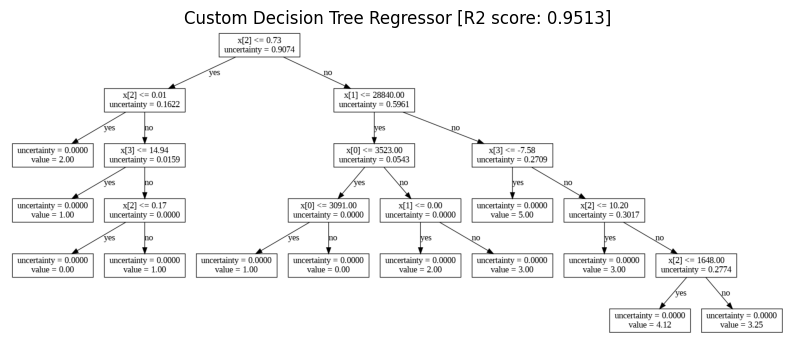

In [227]:
visualize_tree(custom_tree.tree, path="/content/regression_custom.png", tree_source="custom", tree_type="regression", max_depth=MAX_DEPTH)

plt.figure(figsize=(10, 8))
plt.imshow(Image.open("/content/regression_custom.png"))
plt.axis("off")
plt.title(f'Custom Decision Tree Regressor [R2 score: {r2:.4f}]')

plt.savefig("/content/regression_custom.png", bbox_inches="tight")

In [228]:
custom_tree.prune(X_test, y_test)

In [229]:
start_time = datetime.now()

y_pred = custom_tree.predict(X_test)

end_time = datetime.now()

# Metrics
r2 = r2_score(y_test, y_pred)

print(f"\nReference Decision Tree Regressor after prunning")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nR2 score: {r2:.4f}")


Reference Decision Tree Regressor after prunning

Execution Time: 1358 mcs

R2 score: 0.9610


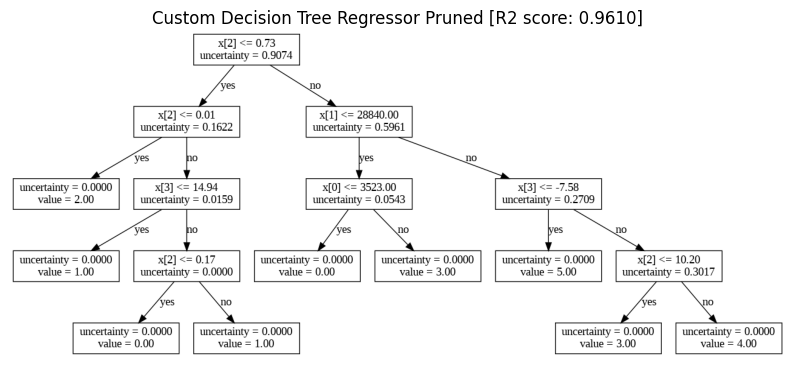

In [230]:
visualize_tree(custom_tree.tree, path="/content/regression_custom_prun.png", tree_source="custom", tree_type="regression", max_depth=MAX_DEPTH)

plt.figure(figsize=(10, 8))
plt.imshow(Image.open("/content/regression_custom_prun.png"))
plt.axis("off")
plt.title(f'Custom Decision Tree Regressor Pruned [R2 score: {r2:.4f}]')

plt.savefig("/content/regression_custom_prun.png", bbox_inches="tight")